<a href="https://colab.research.google.com/github/mathun3003/sightseeing_muenster/blob/main/notebooks/model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import shutil
import random
from tqdm.auto import tqdm
from pathlib import Path

import torch
import torch.nn as nn
from torch.utils.data import DataLoader

import torchvision
from torchvision import transforms, datasets

from google.colab import drive

In [ ]:
# setup pytorch specs
NUM_WORKERS = os.cpu_count()
device = 'cuda' if torch.cuda.is_available() else 'cpu'
# Set the device globally
# torch.set_default_device(device)
print(device)

cuda


In [ ]:
# mount images from gdrive
drive.mount('/content/drive/', force_remount=True)
# set data path
data_dir = Path("/content/drive/My Drive/sight_seeing_ms/data/")
all_dir = data_dir.joinpath('all/')
train_dir = data_dir.joinpath('train/')
test_dir = data_dir.joinpath('test/')

Mounted at /content/drive/


In [ ]:
# only run if train and test dirs are empty
if (not os.listdir(train_dir)) and (not os.listdir(test_dir)):

  # Create the 'train' and 'test' folders if they don't exist
  os.makedirs(train_dir, exist_ok=True)
  os.makedirs(test_dir, exist_ok=True)

  # Iterate through each folder
  for folder_name in tqdm(os.listdir(all_dir), f'Creating train and test dirs from {all_dir}'):
      folder_path = os.path.join(all_dir, folder_name)

      # Create 'train' and 'test' subfolders within each source folder
      train_subfolder = os.path.join(train_dir, folder_name)
      test_subfolder = os.path.join(test_dir, folder_name)
      os.makedirs(train_subfolder, exist_ok=True)
      os.makedirs(test_subfolder, exist_ok=True)

      # Get a list of image files in the current folder
      image_files = [f for f in os.listdir(folder_path)]

      # Shuffle the image files randomly
      random.shuffle(image_files)

      # Calculate the split point based on the 80/20 ratio
      split_point = int(len(image_files) * 0.8)

      # Copy 80% of the images to the 'train' folder
      for file_name in tqdm(image_files[:split_point], f"Copying files for train set from {folder_name}"):
          src_path = os.path.join(folder_path, file_name)
          dst_path = os.path.join(train_subfolder, file_name)
          shutil.copy(src_path, dst_path)

      # Copy 20% of the images to the 'test' folder
      for file_name in tqdm(image_files[split_point:], f"Copying files for test set from {folder_name}"):
          src_path = os.path.join(folder_path, file_name)
          dst_path = os.path.join(test_subfolder, file_name)
          shutil.copy(src_path, dst_path)
else:
  print('Train and Test directories already exist.')

Train and Test directories already exist.


In [ ]:
with torch.device('cpu'):

  # get mean and std for image normalization

  norm_params = {train_dir: {'mean': 0, 'std': 0}, test_dir: {'mean': 0, 'std': 0}}

  for dir in tqdm([train_dir, test_dir], "Progress"):
    dataset = datasets.ImageFolder(dir,
                                  transform=transforms.Compose([
                                      transforms.Resize(size=(224, 224)),
                                      transforms.ToTensor()
                                      ]))

    loader = DataLoader(dataset,
                        batch_size=10,
                        num_workers=NUM_WORKERS,
                        shuffle=False,
                        drop_last=False)

    mean = 0.0
    for images, _ in tqdm(loader, f"Calculating mean for {dir}"):
        images = images
        batch_samples = images.size(0)
        images = images.view(batch_samples, images.size(1), -1)
        mean += images.mean(2).sum(0)
    mean = mean / len(loader.dataset)

    var = 0.0
    pixel_count = 0
    for images, _ in tqdm(loader, f"Calculating std for {dir}"):
        images = images
        batch_samples = images.size(0)
        images = images.view(batch_samples, images.size(1), -1)
        var += ((images - mean.unsqueeze(1))**2).sum([0,2])
        pixel_count += images.nelement()
    std = torch.sqrt(var / pixel_count)

    norm_params[dir]['mean'] = mean
    norm_params[dir]['std'] = std

Progress:   0%|          | 0/2 [00:00<?, ?it/s]

Calculating mean for /content/drive/My Drive/sight_seeing_ms/data/train:   0%|          | 0/57 [00:00<?, ?it/s…

Calculating std for /content/drive/My Drive/sight_seeing_ms/data/train:   0%|          | 0/57 [00:00<?, ?it/s]

Calculating mean for /content/drive/My Drive/sight_seeing_ms/data/test:   0%|          | 0/15 [00:00<?, ?it/s]

Calculating std for /content/drive/My Drive/sight_seeing_ms/data/test:   0%|          | 0/15 [00:00<?, ?it/s]

In [ ]:
# transform data
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(**norm_params[train_dir])
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(**norm_params[test_dir])
])

# create data sets
train_data = datasets.ImageFolder(train_dir, transform=train_transform)
test_data = datasets.ImageFolder(test_dir, transform=test_transform)

class_names = train_data.classes
class_dict = train_data.class_to_idx

# Check the lengths
print(len(train_data), len(test_data))

570 146


In [ ]:
print(class_dict)
print(norm_params)

{'Aasee Münster': 0, 'Erbdrostenhof Münster': 1, 'Hafen Münster': 2, 'LWL-Museum für Kunst und Kultur Münster': 3, 'Rathaus Münster': 4, 'Sankt Lamberti Münster': 5, 'Schloss Münster': 6, 'St. Paulus Dom Münster': 7}
{PosixPath('/content/drive/My Drive/sight_seeing_ms/data/train'): {'mean': tensor([0.4492, 0.4665, 0.4666]), 'std': tensor([0.1494, 0.1492, 0.1722])}, PosixPath('/content/drive/My Drive/sight_seeing_ms/data/test'): {'mean': tensor([0.4406, 0.4552, 0.4622]), 'std': tensor([0.1484, 0.1475, 0.1720])}}


In [ ]:
# define dataloaders
train_dataloader = DataLoader(dataset=train_data,
                              batch_size=10,
                              num_workers=NUM_WORKERS,
                              generator=torch.Generator(device='cpu'),
                              shuffle=True)

test_dataloader = DataLoader(dataset=test_data,
                            batch_size=10,
                            num_workers=NUM_WORKERS,
                            generator=torch.Generator(device='cpu'),
                            shuffle=False)

In [ ]:
# define model
class EfficientNetV2S(nn.Module):
    def __init__(self, fan_out: int, class_to_idx: dict[str, int]):
        """
        Creates a pretrained EfficientNetV2S model with a custom classifier.
        :param fan_out: Number of classes.
        :param: class_to_idx: Class to index mapping dictionary.
        """
        super().__init__()
        self.class_to_idx = class_to_idx
        self.weights = torchvision.models.EfficientNet_V2_S_Weights.DEFAULT
        self.model = torchvision.models.efficientnet_v2_s(weights=self.weights)
        self.model.classifier = torch.nn.Sequential(
            nn.Dropout(p=0.2, inplace=True),
            nn.Linear(in_features=1280,
                      out_features=fan_out,
                      bias=True))
        # freeze base layers
        for param in self.model.features.parameters():
            param.requires_grad = False

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.model(x)

    def save(self, model_path: str | Path):
        torch.save({
            'model_state_dict': self.model.state_dict(),
            'class_to_idx': self.class_to_idx
        }, model_path)

In [ ]:
def train_step(model: torch.nn.Module | OptimizedModule,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device: torch.device) -> tuple[float, float]:
  """Trains a PyTorch model for a single epoch.

  Turns a target PyTorch model to training mode and then
  runs through all of the required training steps (forward
  pass, loss calculation, optimizer step).

  Args:
    model: A PyTorch model to be trained.
    dataloader: A DataLoader instance for the model to be trained on.
    loss_fn: A PyTorch loss function to minimize.
    optimizer: A PyTorch optimizer to help minimize the loss function.
    device: A target device to compute on (e.g. "cuda" or "cpu").

  Returns:
    A tuple of training loss and training accuracy metrics.
    In the form (train_loss, train_accuracy). For example:

    (0.1112, 0.8743)
  """
  # Put model in train mode
  model.train()

  # Setup train loss and train accuracy values
  train_loss, train_acc = 0, 0

  # Loop through data loader data batches
  for batch, (X, y) in enumerate(dataloader):
      # Send data to target device
      X, y = X.to(device), y.to(device)

      # 1. Forward pass
      y_pred = model(X)

      # 2. Calculate  and accumulate loss
      loss = loss_fn(y_pred, y)
      train_loss += loss.item()

      # 3. Optimizer zero grad
      optimizer.zero_grad()

      # 4. Loss backward
      loss.backward()

      # 5. Optimizer step
      optimizer.step()

      # Calculate and accumulate accuracy metric across all batches
      y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
      train_acc += (y_pred_class == y).sum().item()/len(y_pred)

  # Adjust metrics to get average loss and accuracy per batch
  train_loss = train_loss / len(dataloader)
  train_acc = train_acc / len(dataloader)
  return train_loss, train_acc

def test_step(model: torch.nn.Module | OptimizedModule,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device: torch.device) -> tuple[float, float]:
  """Tests a PyTorch model for a single epoch.

  Turns a target PyTorch model to "eval" mode and then performs
  a forward pass on a testing dataset.

  Args:
    model: A PyTorch model to be tested.
    dataloader: A DataLoader instance for the model to be tested on.
    loss_fn: A PyTorch loss function to calculate loss on the test data.
    device: A target device to compute on (e.g. "cuda" or "cpu").

  Returns:
    A tuple of testing loss and testing accuracy metrics.
    In the form (test_loss, test_accuracy). For example:

    (0.0223, 0.8985)
  """
  # Put model in eval mode
  model.eval()

  # Setup test loss and test accuracy values
  test_loss, test_acc = 0, 0

  # Turn on inference context manager
  with torch.inference_mode():
      # Loop through DataLoader batches
      for batch, (X, y) in enumerate(dataloader):
          # Send data to target device
          X, y = X.to(device), y.to(device)

          # 1. Forward pass
          test_pred_logits = model(X)

          # 2. Calculate and accumulate loss
          loss = loss_fn(test_pred_logits, y)
          test_loss += loss.item()

          # Calculate and accumulate accuracy
          test_pred_labels = test_pred_logits.argmax(dim=1)
          test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))

  # Adjust metrics to get average loss and accuracy per batch
  test_loss = test_loss / len(dataloader)
  test_acc = test_acc / len(dataloader)
  return test_loss, test_acc

def train(model: torch.nn.Module | OptimizedModule,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          epochs: int,
          device: torch.device) -> dict[str, list]:
  """Trains and tests a PyTorch model.

  Passes a target PyTorch models through train_step() and test_step()
  functions for a number of epochs, training and testing the model
  in the same epoch loop.

  Calculates, prints and stores evaluation metrics throughout.

  Args:
    model: A PyTorch model to be trained and tested.
    train_dataloader: A DataLoader instance for the model to be trained on.
    test_dataloader: A DataLoader instance for the model to be tested on.
    optimizer: A PyTorch optimizer to help minimize the loss function.
    loss_fn: A PyTorch loss function to calculate loss on both datasets.
    epochs: An integer indicating how many epochs to train for.
    device: A target device to compute on (e.g. "cuda" or "cpu").

  Returns:
    A dictionary of training and testing loss as well as training and
    testing accuracy metrics. Each metric has a value in a list for
    each epoch.
    In the form: {train_loss: [...],
                  train_acc: [...],
                  test_loss: [...],
                  test_acc: [...]}
    For example if training for epochs=2:
                 {train_loss: [2.0616, 1.0537],
                  train_acc: [0.3945, 0.3945],
                  test_loss: [1.2641, 1.5706],
                  test_acc: [0.3400, 0.2973]}
  """
  # Create empty results dictionary
  results = {"train_loss": [],
      "train_acc": [],
      "test_loss": [],
      "test_acc": []
  }

  # Loop through training and testing steps for a number of epochs
  for epoch in tqdm(range(epochs)):
      train_loss, train_acc = train_step(model=model,
                                          dataloader=train_dataloader,
                                          loss_fn=loss_fn,
                                          optimizer=optimizer,
                                          device=device)
      test_loss, test_acc = test_step(model=model,
          dataloader=test_dataloader,
          loss_fn=loss_fn,
          device=device)

      # Print out what's happening
      print(
          f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_acc: {train_acc:.4f} | "
          f"test_loss: {test_loss:.4f} | "
          f"test_acc: {test_acc:.4f}"
      )

      # Update results dictionary
      results["train_loss"].append(train_loss)
      results["train_acc"].append(train_acc)
      results["test_loss"].append(test_loss)
      results["test_acc"].append(test_acc)

  # Return the filled results at the end of the epochs
  return results

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [ ]:
model = EfficientNetV2S(fan_out=len(class_names), class_to_idx=class_dict)

# train model
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

results = train(model=model.to(device),
                train_dataloader=train_dataloader,
                test_dataloader=test_dataloader,
                optimizer=optimizer,
                loss_fn=loss_fn,
                epochs=20,
                device=device)

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.4831 | train_acc: 0.5596 | test_loss: 1.0303 | test_acc: 0.8244
Epoch: 2 | train_loss: 0.8811 | train_acc: 0.7965 | test_loss: 0.6876 | test_acc: 0.9200
Epoch: 3 | train_loss: 0.6636 | train_acc: 0.8667 | test_loss: 1.4547 | test_acc: 0.9400
Epoch: 4 | train_loss: 0.4949 | train_acc: 0.8965 | test_loss: 0.4447 | test_acc: 0.9467
Epoch: 5 | train_loss: 0.4602 | train_acc: 0.8860 | test_loss: 0.3706 | test_acc: 0.9667
Epoch: 6 | train_loss: 0.4262 | train_acc: 0.9070 | test_loss: 0.3088 | test_acc: 0.9733
Epoch: 7 | train_loss: 0.3733 | train_acc: 0.9105 | test_loss: 0.2800 | test_acc: 0.9489
Epoch: 8 | train_loss: 0.3744 | train_acc: 0.9193 | test_loss: 0.2896 | test_acc: 0.9533
Epoch: 9 | train_loss: 0.3279 | train_acc: 0.9158 | test_loss: 0.3111 | test_acc: 0.9489
Epoch: 10 | train_loss: 0.2858 | train_acc: 0.9246 | test_loss: 0.2422 | test_acc: 0.9600
Epoch: 11 | train_loss: 0.2699 | train_acc: 0.9246 | test_loss: 0.2218 | test_acc: 0.9489
Epoch: 12 | train_l

In [ ]:
# save model parameters
model_path = Path('/content/drive/My Drive/sight_seeing_ms/models/')

model_name = "01_pytorch_efficientnetv2s.pth"
model_save_path = model_path / model_name

model.save(model_save_path)

## TensorFlow

In [ ]:
from google.colab import drive
import tensorflow as tf
import matplotlib.pyplot as plt
import json
import os, sys
import cv2
import numpy as np
from PIL import Image
import logging
import time
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
import requests
from io import BytesIO
import shutil

# suppress warnings from augmentation
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

In [ ]:
!pip install pyyaml h5py  # Required to save models in HDF5 format

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# mount images from gdrive
drive.mount('/content/drive/', force_remount=True)

imgs_path = "/Sight_Seeking/data/"
base_path = "/content/drive/My Drive"
gdrive_path = base_path + imgs_path

# imgs dirs
dirs = next(os.walk(gdrive_path))[1]
# add slash to each dir
dirs = [dir + "/" for dir in dirs]

Mounted at /content/drive/


In [ ]:
# load train and test sets
images_train, images_test, labels_train, labels_test = np.load(f"{base_path}/train_test_sets/images_train.npy"), np.load(f"{base_path}/train_test_sets/images_test.npy"), np.load(f"{base_path}/train_test_sets/labels_train.npy"), np.load(f"{base_path}/train_test_sets/labels_test.npy")

In [ ]:
# create base model
base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2S(
                                              input_shape=(224,224,3),
                                              include_top=False,
                                              weights='imagenet')

# create data augmentation layers
data_augmentation = tf.keras.Sequential([
  keras.layers.RandomFlip("horizontal_and_vertical", input_shape=(224,224,3)),
  keras.layers.RandomRotation(0.2)
])

# add last layers, build final model
model = tf.keras.Sequential([
  # data_augmentation,
  base_model,
  keras.layers.GlobalAveragePooling2D(),
  keras.layers.Dense(12, activation="softmax")
])

config = model.get_config()

In [ ]:
# view model summary
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetv2-s (Functiona  (None, 7, 7, 1280)       20331360  
 l)                                                              
                                                                 
 global_average_pooling2d_1   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_1 (Dense)             (None, 12)                15372     
                                                                 
Total params: 20,346,732
Trainable params: 15,372
Non-trainable params: 20,331,360
_________________________________________________________________


In [ ]:
# freeze pretraind layers
for layer in model.layers[:-1]:
  layer.trainable = False

# optimizer
opt = keras.optimizers.Adam(learning_rate=0.001)

# compile model
model.compile(loss="CategoricalCrossentropy", optimizer=opt, metrics=["accuracy", tf.keras.metrics.Precision(),tf.keras.metrics.Recall()])

# train model
model.fit(images_train, labels_train, epochs=5, validation_split=0.1)

Epoch 1/5
13/13 [==============================] - 20s 440ms/step - loss: 1.9914 - accuracy: 0.3680 - precision_2: 0.0000e+00 - recall_2: 0.0000e+00 - val_loss: 1.3367 - val_accuracy: 0.7727 - val_precision_2: 0.0000e+00 - val_recall_2: 0.0000e+00
Epoch 2/5
13/13 [==============================] - 2s 153ms/step - loss: 1.1436 - accuracy: 0.7487 - precision_2: 1.0000 - recall_2: 0.1827 - val_loss: 0.8548 - val_accuracy: 0.9091 - val_precision_2: 1.0000 - val_recall_2: 0.4091
Epoch 3/5
13/13 [==============================] - 2s 150ms/step - loss: 0.7105 - accuracy: 0.9289 - precision_2: 1.0000 - recall_2: 0.5457 - val_loss: 0.6091 - val_accuracy: 0.9545 - val_precision_2: 1.0000 - val_recall_2: 0.6591
Epoch 4/5
13/13 [==============================] - 2s 132ms/step - loss: 0.5200 - accuracy: 0.9340 - precision_2: 0.9967 - recall_2: 0.7665 - val_loss: 0.4768 - val_accuracy: 0.9545 - val_precision_2: 0.9714 - val_recall_2: 0.7727
Epoch 5/5
13/13 [==============================] - 2s 132ms

In [ ]:
# Evaluate the model on the test set
test_loss, test_acc, test_precision, test_recall = model.evaluate(images_test, labels_test)
print(f"""
loss: {test_loss} \naccuracy: {test_acc} \nprecision: {test_precision} \nrecall: {test_recall}
""")

6/6 [==============================] - 1s 124ms/step - loss: 0.3834 - accuracy: 0.9840 - precision_2: 1.0000 - recall_2: 0.8351

loss: 0.3834156394004822 
accuracy: 0.9840425252914429 
precision: 1.0 
recall: 0.835106372833252



In [ ]:
# save model weights
for layer in model.layers:
  layer.trainable = False
model.save_weights(base_path+'/Sight_Seeking/effNetV2_model_weights.h5')

## Testing the model with a new image from web

In [ ]:
import requests
from io import BytesIO
# download test image
url = "https://www.feineart.de/wp-content/uploads/2020/02/Schlo%C3%9F-lila-STA_382_3-2.jpg"

response = requests.get(url, stream=True)
img = Image.open(BytesIO(response.content)).resize((224,224), Image.ANTIALIAS).convert("RGB")
img_array = np.array(img)
img_array = np.expand_dims(img_array, axis=0)

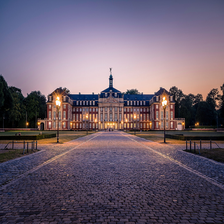

In [ ]:
# display image
img

In [ ]:
results = model.predict(img_array)

1/1 [==============================] - 7s 7s/step


In [ ]:
np.argmax(results[0])

0

In [ ]:
with open('/content/drive/My Drive/Sight_Seeking/labels.json', "r") as f:
    legend= json.load(f)

legend

{'Schloss_Münster': 0,
 'St._Paulus_Dom_Münster': 1,
 'Erbdrostenhof_münster': 2,
 'kiepenkerl_denkmal_münster': 3,
 'LWL-Museum_für_kunst_und_kultur_münster': 4,
 'Sankt_Lamberti_Münster': 5,
 'Buddenturm_Münster': 6,
 'Aaseekugeln_Münster': 7,
 'Antiquariat_Münster': 8,
 'Provinzial_Münster': 9,
 'Cavete_Münster': 10,
 'Rathaus_Münster': 11}